<a href="https://colab.research.google.com/github/BME6938-SPR2023/final_project/blob/main/PelvicSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies

In [2]:
!pip install -q transformers datasets evaluate monai

## import libraries

In [3]:
#NEED to delect unused libraries
import os as os
from glob import glob
import shutil
from tqdm import tqdm
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from torch import nn
import monai
import evaluate
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import cv2
import PIL
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize, rotate
# import SimpleITK as sitk
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import torchvision.transforms as transforms
from PIL import Image
from transformers import SegformerFeatureExtractor,SegformerImageProcessor, AutoImageProcessor, TrainingArguments, Trainer

## HF Login

In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
hf_username = "ashiyakatuka11"

## Data preparation: 
#### convert nii to png and remove slices without matching labels
- Resized and rotated images 
- Reduced the dataset by only including images that match with segmentation masks with 1 or both labels
- There is an option for converting from .nii to .png

In [ ]:
#data cleaning 1: use stacked data/ labels to get label list
def clean_data(input_folder, output_folder, image_processor): 
  #first remove matched images without labels

  img_folder_path = '/stacked_sliced/train' #switch "train" to "test"
  lbl_folder_path = '/prostate_femur_sliced/train'

  img_dir = input_folder + img_folder_path
  label_dir = input_folder + lbl_folder_path

  labels_paths = []

  img_paths = sorted([os.path.join( img_dir, x) for x in os.listdir( img_dir)])
  labels_paths = sorted([os.path.join(label_dir, x) for x in os.listdir(label_dir)])

  for i_img,i_mask in zip(img_paths,labels_paths):
    img_rename = os.path.splitext(os.path.basename(i_img))[0]
    label_rename = os.path.splitext(os.path.basename(i_mask))[0]

    Reading_Img_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)

    img_arr = Reading_Img_NII.get_fdata()
    mask_arr = Reading_Label_NII.get_fdata()
    
     # Define the new size for the resized image
    new_size = (512, 512)
    
    # Resize the image using the resize() function from skimage
    img_resized = resize(img_arr, new_size, anti_aliasing=True)
    mask_resized = resize(mask_arr, new_size, anti_aliasing=True)

    # Rotate the image using the rotate() function from skimage
    angle = 90
    img_resized = rotate(img_resized , angle)
    mask_resized = rotate(mask_resized, angle)

    # Normalized 
    img_arr_norm = (img_resized- img_resized.min()) / (img_resized.max() - img_resized.min())
    pil_image = Image.fromarray((img_arr_norm * 255).astype(np.uint8))

    label_arr_norm = (mask_resized - mask_resized.min()) / (mask_resized .max() - mask_resized.min())
    pil_label = Image.fromarray((label_arr_norm* 255).astype(np.uint8)) 

    pil_image_T = np.stack([pil_image ] * 3, axis=-1).transpose((2,1,0))
    encoded_inputs = image_processor(pil_image_T, pil_label, return_tensors="pt")

    labels = encoded_inputs["labels"].squeeze().unique()
    if len(labels) > 2:
      labels_paths.append(i_mask )
      print(i_img)
      #save stack slices with labels
      pil_image.save(f'/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2{img_folder_path}/{img_rename}.png')
      pil_label.save(f'/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2{lbl_folder_path}/{label_rename}.png')
  return(labels_paths)

In [ ]:
def clean_data2(input_folder,output_folder):
  img_folder_path = '/T2_sliced/test' #switch "train" to "test"
  lbl_folder_path = '/prostate_femur_sliced/test'
  newlbl_folder_path = '/prostate_femur_sliced/test'

  img_dir = input_folder + img_folder_path
  label_dir = input_folder + lbl_folder_path
  newlabel_dir = output_folder + lbl_folder_path

  img_paths = sorted([os.path.join(img_dir, x) for x in os.listdir(img_dir)])
  labels_paths = sorted([os.path.join(label_dir, x) for x in os.listdir(label_dir)])
  newlabels_paths = sorted([os.path.join(newlabel_dir, x) for x in os.listdir(newlabel_dir)])

  for i_img,i_mask in zip(img_paths,labels_paths):
    img_rename = os.path.splitext(os.path.basename(i_img))[0]
    label_rename = os.path.splitext(os.path.basename(i_mask))[0]
    for new_mask in newlabels_paths:
      newlabel_rename = os.path.splitext(os.path.basename(new_mask))[0]
      if (label_rename == newlabel_rename):
        Reading_Img_NII = nib.load(i_img)
        # Reading_Label_NII = nib.load(i_mask)

        img_arr = Reading_Img_NII.get_fdata()
        # mask_arr = Reading_Label_NII.get_fdata()
        
        # Define the new size for the resized image
        new_size = (512, 512)
        
        # Resize the image using the resize() function from skimage
        img_resized = resize(img_arr, new_size, anti_aliasing=True)
        # mask_resized = resize(mask_arr, new_size, anti_aliasing=True)

        # Rotate the image using the rotate() function from skimage
        angle = 90
        img_resized = rotate(img_resized , angle)
        # mask_resized = rotate(mask_resized, angle)

        img_arr_norm = (img_resized- img_resized.min()) / (img_resized.max() - img_resized.min())
        pil_image = Image.fromarray((img_arr_norm * 255).astype(np.uint8))

        # label_arr_norm = (mask_resized - mask_resized.min()) / (mask_resized .max() - mask_resized.min())
        # pil_label = Image.fromarray((label_arr_norm* 255).astype(np.uint8))

        print(i_img)
        #save stack slices with labels
        pil_image.save(f'/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2{img_folder_path}/{img_rename}.png')
        # pil_image.save(f'/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2{lbl_folder_path}/{label_rename}.png')
  print("Done")


In [ ]:
folder_path = "/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack" #folder with original images
output_path = "/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2" #folder where new images will be saved

In [ ]:
image_processor = SegformerImageProcessor(use_python_backend=False)


In [ ]:
clean_data(folder_path,output_path, image_processor) #Run ONLY TWICE for stacked/label train and stacked/label test


In [ ]:
clean_data2(folder_path,output_path) #Run 4 times for T2 and dCT2  train and T2 and dCT2l test

### .nii reduced

In [ ]:
#data cleaning 1: use stacked data/ labels to get label list
import shutil
def reduced_data(input_folder, output_path, image_processor): 
  #first remove matched images without labels
 
  img_folder_path = '/stacked_sliced/train' #switch "train" to "test"
  lbl_folder_path = '/prostate_femur_sliced/train'

  # new_folder_path = newfolder/img_folder_path
  # !mkdir /content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack_reduced/stacked_sliced/test
  # !mkdir /content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack_reduced/stacked_sliced/test

  img_dir = input_folder + img_folder_path
  label_dir = input_folder + lbl_folder_path

  out_img_dir = output_path + img_folder_path
  out_lbl_dir = output_path + lbl_folder_path

  labels_paths = []

  img_paths = sorted([os.path.join( img_dir, x) for x in os.listdir( img_dir)])
  labels_paths = sorted([os.path.join(label_dir, x) for x in os.listdir(label_dir)])

  for i_img,i_mask in zip(img_paths,labels_paths):
    img_rename = os.path.splitext(os.path.basename(i_img))
    label_rename = os.path.splitext(os.path.basename(i_mask))

    Reading_Img_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)

    img_arr = Reading_Img_NII.get_fdata()
    mask_arr = Reading_Label_NII.get_fdata()
    
     # Define the new size for the resized image
    new_size = (512, 512)
    
    # Resize the image using the resize() function from skimage
    img_resized = resize(img_arr, new_size, anti_aliasing=True)
    mask_resized = resize(mask_arr, new_size, anti_aliasing=True)

    # Rotate the image using the rotate() function from skimage
    angle = 90
    img_resized = rotate(img_resized , angle)
    mask_resized = rotate(mask_resized, angle)

    img_arr_norm = (img_resized- img_resized.min()) / (img_resized.max() - img_resized.min())
    pil_image = Image.fromarray((img_arr_norm * 255).astype(np.uint8))

    label_arr_norm = (mask_resized - mask_resized.min()) / (mask_resized .max() - mask_resized.min())
    pil_label = Image.fromarray((label_arr_norm* 255).astype(np.uint8)) 

    pil_image_T = np.stack([pil_image ] * 3, axis=-1).transpose((2,1,0))
    encoded_inputs = image_processor(pil_image_T, pil_label, return_tensors="pt")

    labels = encoded_inputs["labels"].squeeze().unique()
    if len(labels) > 2:
      labels_paths.append(i_mask )
      print(i_img)
      #save stack slices with labels
      shutil.copy(i_img, out_img_dir )
      # shutil.copy(i_mask,out_lbl_dir )
  return(labels_paths)

In [ ]:
def reduced_data2(input_folder,output_path):
  img_folder_path = '/stacked_sliced/train' #switch "train" to "test"
  lbl_folder_path = '/prostate_femur_sliced/train'
  newlbl_folder_path = '/prostate_femur_sliced/test'

  img_dir = input_folder + img_folder_path
  label_dir = input_folder + lbl_folder_path
  newlabel_dir = output_path + lbl_folder_path

  out_img_dir = output_path + img_folder_path
  # out_lbl_dir = output_path + lbl_folder_path

  img_paths = sorted([os.path.join(img_dir, x) for x in os.listdir(img_dir)])
  labels_paths = sorted([os.path.join(label_dir, x) for x in os.listdir(label_dir)])
  newlabels_paths = sorted([os.path.join(newlabel_dir, x) for x in os.listdir(newlabel_dir)])

  for i_img,i_mask in zip(img_paths,labels_paths):
    img_rename = os.path.splitext(os.path.basename(i_img))
    label_rename = os.path.splitext(os.path.basename(i_mask))
    for new_mask in newlabels_paths:
      newlabel_rename = os.path.splitext(os.path.basename(new_mask))
      if (label_rename == newlabel_rename):
        Reading_Img_NII = nib.load(i_img)
        # Reading_Label_NII = nib.load(i_mask)

        img_arr = Reading_Img_NII.get_fdata()
        # mask_arr = Reading_Label_NII.get_fdata()
        
        # Define the new size for the resized image
        new_size = (512, 512)
        
        # Resize the image using the resize() function from skimage
        img_resized = resize(img_arr, new_size, anti_aliasing=True)
        # mask_resized = resize(mask_arr, new_size, anti_aliasing=True)

        # Rotate the image using the rotate() function from skimage
        angle = 90
        img_resized = rotate(img_resized , angle)
        # mask_resized = rotate(mask_resized, angle)

        img_arr_norm = (img_resized- img_resized.min()) / (img_resized.max() - img_resized.min())
        pil_image = Image.fromarray((img_arr_norm * 255).astype(np.uint8))

        # label_arr_norm = (mask_resized - mask_resized.min()) / (mask_resized .max() - mask_resized.min())
        # pil_label = Image.fromarray((label_arr_norm* 255).astype(np.uint8))

        print(i_img)
        #save stack slices with labels
        shutil.copy(i_img,out_img_dir )
        # pil_image.save(f'/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2{lbl_folder_path}/{label_rename}.png')
  print("Done")

In [ ]:
folder_path = "/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack"
output_path = "/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack_reduced"

In [ ]:
image_processor = SegformerImageProcessor(use_python_backend=False)

In [ ]:
reduced_data(folder_path,output_path, image_processor) #Run ONLY TWICE for stacked/label train and stacked/label test

In [ ]:
reduced_data2(folder_path,output_path) #Run 4 times for T2 and dCT2  train and T2 and dCT2l test

## Load the data 

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# folder_path = "/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2" #new directory with new .png images 

In [5]:
folder_path = "/content/drive/MyDrive/BME6938 CIS6930(SPR2023) - Cats Can/code_data/GoldA_ZNew"  #new directory with new reduced .nii images 

### check labels 

In [ ]:
#sample image/label
img_path = "/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2/stacked_sliced/train/P3_04_stack_Z48.png"
lbl_path = "/content/drive/MyDrive/Colab_Notebooks/datasets/GoldA_ZStack2/prostate_femur_sliced/train/3_04_prostate_femur_Z48.png"
img = Image.open(img_path)
label= Image.open(lbl_path)
label_arr = np.array(label)
print(np.unique(label_arr))

#visualize image/mask

# figure,axis = plt.subplots(1,2,figsize=(10,10))
# # Plot_Color_Op = axis[0].imshow(img)
# axis[0].imshow(img)
# axis[0].set_xlabel(img.size)
# axis[0].set_ylabel(img.size)
# axis[0].set_title("IMAGE")

# axis[1].imshow(label)
# axis[1].set_xlabel(label.size)
# axis[1].set_ylabel(label.size)
# axis[1].set_title("MASK")

[  0 254 255]


[0. 1. 2.]
3


Text(0.5, 1.0, 'MASK')

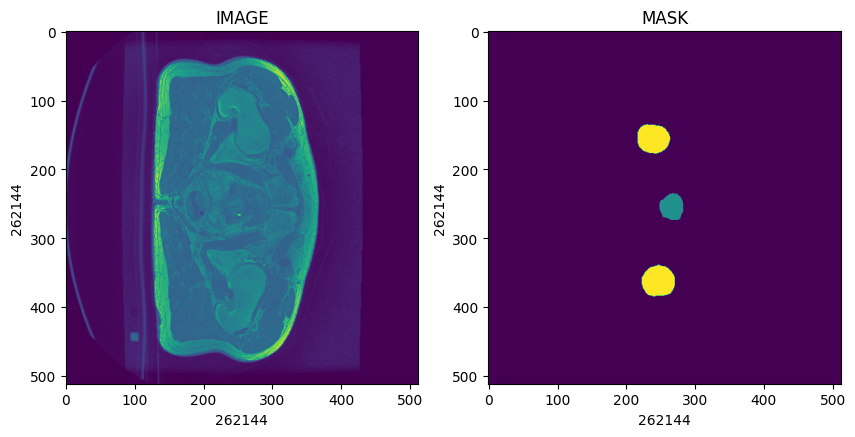

In [9]:
#sample image/label
img_path = folder_path + "/stacked_sliced/train/P1_02_stack_Z48.nii"
lbl_path = folder_path + "/prostate_femur_sliced/train/1_02_prostate_femur_Z48.nii"


Reading_Img_NII = nib.load(img_path)
Reading_Label_NII = nib.load(lbl_path)

img = Reading_Img_NII.get_fdata()
label = Reading_Label_NII.get_fdata()
print(np.unique(label))
print(len(np.unique(label)))
#visualize image/mask
figure,axis = plt.subplots(1,2,figsize=(10,10))

Plot_Color_Op = axis[0].imshow(img)
axis[0].imshow(img)
axis[0].set_xlabel(img.size)
axis[0].set_ylabel(img.size)
axis[0].set_title("IMAGE")

axis[1].imshow(label)
axis[1].set_xlabel(label.size)
axis[1].set_ylabel(label.size)
axis[1].set_title("MASK")

### Get the unique labels

In [ ]:
#data cleaning 1: use stacked data/ labels to get label list
def unique_data(input_folder): 

  lbl_folder_path = '/prostate_femur_sliced/test'
  label_dir = input_folder + lbl_folder_path

  labels_paths = []
  labels_paths = sorted([os.path.join(label_dir, x) for x in os.listdir(label_dir)])

  for i_mask in labels_paths:
    Reading_Label_NII = nib.load(i_mask)
    mask_arr = Reading_Label_NII.get_fdata()
    
    print(np.unique(mask_arr))
  return("done")

In [ ]:
unique_data(folder_path)

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 2.]
[0. 2.]
[0. 2.]
[0. 2.]
[0. 2.]
[0. 2.]


'done'

### load image/label directories

In [9]:
## directory paths for all datasets

##train
tr_stk_img_dir=folder_path + '/stacked_sliced/train'
tr_t2_img_dir=folder_path + '/T2_sliced/train'
tr_dct_img_dir=folder_path + '/dÇT2_sliced/train'
tr_labels_dir=folder_path +'/prostate_femur_sliced/train'
# tr_newlabels_dir=folder_path +'/prostate/train'

##test
ts_stk_img_dir=folder_path + '/stacked_sliced/test'
ts_t2_img_dir=folder_path + '/T2_sliced/test'
ts_dct_img_dir=folder_path + '/dÇT2_sliced/test'
ts_labels_dir=folder_path +'/prostate_femur_sliced/test'

In [10]:
tr_stk_img_paths = sorted([os.path.join(tr_stk_img_dir, x) for x in os.listdir(tr_stk_img_dir)])
tr_t2_img_paths = sorted([os.path.join(tr_t2_img_dir, x) for x in os.listdir(tr_t2_img_dir)])
tr_dct_img_paths = sorted([os.path.join(tr_dct_img_dir, x) for x in os.listdir(tr_dct_img_dir)])
tr_labels_paths = sorted([os.path.join(tr_labels_dir, x) for x in os.listdir(tr_labels_dir)])
# tr_newlabels_paths = sorted([os.path.join(tr_newlabels_dir, x) for x in os.listdir(tr_newlabels_dir)])

ts_stk_img_paths = sorted([os.path.join(ts_stk_img_dir, x) for x in os.listdir(ts_stk_img_dir)])
ts_t2_img_paths = sorted([os.path.join(ts_t2_img_dir, x) for x in os.listdir(ts_t2_img_dir)])
ts_dct_img_paths = sorted([os.path.join(ts_dct_img_dir, x) for x in os.listdir(ts_dct_img_dir)])
ts_labels_paths = sorted([os.path.join(ts_labels_dir, x) for x in os.listdir(ts_labels_dir)])

In [11]:
#check to make sure all images match with labels
print(len(tr_stk_img_paths))
print(len(tr_t2_img_paths))
print(len(tr_dct_img_paths))
print(len(tr_labels_paths))
print("***")
print(len(ts_stk_img_paths))
print(len(ts_t2_img_paths))
print(len(ts_dct_img_paths))
print(len(ts_labels_paths))

15
15
15
15
***
3
3
3
3


## Data Preprocessing
To make them compatible with the SegFormer model from Hugging Face Transformers, we:

- Normalize the images with the mean and standard deviation used during pre-training SegFormer.
- Transpose the images such that they are in "channels_first" format. 

### pelvic segmentation class

In [12]:
### .nii
class NiftiPelvicSegmentationDataset(torch.utils.data.Dataset):
    """Image (pelvic) segmentation dataset."""

    def __init__(self, img_paths, mask_paths,feature_extractor, train=True):
        """
        Args:

        """
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.feature_extractor = feature_extractor
        self.train = train

        assert len(self.img_paths) == len(self.mask_paths), "check that number of images equals number of segmentation masks "

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx): 

        #Load the Nifti image      
        img = nib.load(self.img_paths[idx])
        mask = nib.load(self.mask_paths[idx])

        
        # Convert the Nifti image to a NumPy array
        img_arr = img.get_fdata()
        # mask_arr = mask.get_fdata()
        mask_arr = np.flip(mask.get_fdata(), axis = 1).copy()

        # while len(np.unique(mask_arr)) == 3: 
          # Define the new size for the resized image
        if (img_arr.shape != (512, 512)):
          new_size = (512, 512)
            # Resize the image using the resize() function from skimage
          img_arr= resize(img_arr, new_size, anti_aliasing=True)
          mask_arr = resize(mask_arr, new_size, anti_aliasing=True)

        #Normalize the image
        img_arr = (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min())
        img_arr = np.stack([img_arr ] * 3, axis=-1).transpose((2,1,0))

          # if self.transform is not None:
          #     img_arr = self.transform(img_arr)
          #     mask_arr = self.transform(mask_arr)

        
        # Convert to PyTorch tensors
        img_tensor = torch.from_numpy(img_arr).unsqueeze(0) # Add channel dimension
        mask_tensor = torch.from_numpy(mask_arr).unsqueeze(0) # Add channel dimension

        # pad both image and segmentation map to same size
        inputs = {"pixel_values": img_tensor.squeeze_().float(), "labels": mask_tensor.squeeze_().long()}

         # randomly crop + pad both image and segmentation map to same size
        # encoded_inputs = self.feature_extractor(img_arr, mask_arr, return_tensors="pt")

        # for k,v in encoded_inputs.items():
        #   encoded_inputs[k].squeeze_() # remove batch dimension
        return inputs

In [13]:
feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

In [14]:
stk_train_dataset = NiftiPelvicSegmentationDataset(img_paths=tr_stk_img_paths, mask_paths=tr_labels_paths,feature_extractor=feature_extractor)
stk_valid_dataset = NiftiPelvicSegmentationDataset(img_paths=ts_stk_img_paths, mask_paths=ts_labels_paths,feature_extractor=feature_extractor, train=False)

In [15]:
t2_train_dataset = NiftiPelvicSegmentationDataset(img_paths=tr_t2_img_paths, mask_paths=tr_labels_paths,feature_extractor=feature_extractor)
t2_valid_dataset = NiftiPelvicSegmentationDataset(img_paths=ts_t2_img_paths, mask_paths=ts_labels_paths,feature_extractor=feature_extractor, train=False)

In [16]:
dct_train_dataset = NiftiPelvicSegmentationDataset(img_paths=tr_dct_img_paths, mask_paths=tr_labels_paths,feature_extractor=feature_extractor)
dct_valid_dataset = NiftiPelvicSegmentationDataset(img_paths=ts_dct_img_paths, mask_paths=ts_labels_paths,feature_extractor=feature_extractor, train=False)

### check data 

In [238]:
print("# of training data:", len(stk_train_dataset))
print("# of test data:", len(stk_valid_dataset))

# of training data: 299
# of test data: 51


In [220]:
encoded_inputs = stk_train_dataset[0]
print(encoded_inputs["pixel_values"].shape)
print(encoded_inputs["labels"].shape)
print(encoded_inputs["labels"].squeeze().unique())

torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor([0, 1])


In [221]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 256, 256])

In [222]:
encoded_inputs["labels"].shape

torch.Size([256, 256])

In [207]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [208]:
torch.set_printoptions(edgeitems=encoded_inputs["labels"].numel(), precision=4)


In [ ]:
# np.set_printoptions(threshold=np.inf)
print(encoded_inputs["labels"])

### Get the labels 

In [ ]:
# unique_labels = set()
unique_pixels_list = []
#train data
for i in range(len(stk_train_dataset)):
  unique_pixels = stk_train_dataset[i]["labels"].squeeze().unique()
  if str(unique_pixels) not in unique_pixels_list:
    unique_pixels_list.append(str(unique_pixels))

#test data
for i in range(len(stk_valid_dataset)):
  unique_pixels = stk_valid_dataset[i]["labels"].squeeze().unique()
  if str(unique_pixels) not in unique_pixels_list:
    unique_pixels_list.append(str(unique_pixels))

print(len(unique_pixels_list))
unique_pixels_list

In [ ]:
batch["labels"].shape

## Finetuning the model

In [17]:
#set labels
import json
from huggingface_hub import hf_hub_download

# hf_dataset_identifier = "Cats-Can/image_data"

# filename = "id2label.json"
# id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {0: 'Background',  1: 'Prostate', 2: 'Femur'} 
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)
print(num_labels)

Id2label: {0: 'Background', 1: 'Prostate', 2: 'Femur'}
3


In [18]:
# load model
from transformers import SegformerForSemanticSegmentation

In [19]:
# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=3, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_hea

In [34]:
# define model
model2 = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=3, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_hea

In [43]:
# define model
model3 = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=3, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_hea

In [48]:
# define model
model4 = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=3, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_hea

### Testing model - base test 

In [24]:
from datasets import load_metric

mean_iou_metric = load_metric("mean_iou")
recall_metric = load_metric('recall')
precision_metric = load_metric("precision")
f1_metric = load_metric("f1")
# metric4 = load_metric("erntkn/dice_coefficient")

#### Testing stacked data

In [32]:
labels_list = []
pred_list = []
test_batch = t2_valid_dataset
for idx in range(len(stk_valid_dataset)):
  images = stk_valid_dataset[idx]['pixel_values']
  masks = stk_valid_dataset[idx]['labels']

  images_tensor = images.unsqueeze(0) 
  masks = masks.unsqueeze(0) 

  outputs = model(images_tensor)
  logits = outputs.logits 

  logits_tensor = nn.functional.interpolate(
          logits.to(device),
          size=masks.shape[-2:],
          mode="bilinear",
          align_corners=False,
      ).argmax(dim=1)

  pred_labels = logits_tensor.cpu().numpy()
  # labels = masks.cpu().numpy()
  labels = np.array(masks.cpu())

  labels_list.append(labels)
  pred_list.append(pred_labels )

metrics = mean_iou_metric._compute(
                predictions=pred_list,
                references=labels_list,
                num_labels=len(id2label),
                ignore_index=0,
            )
# add per category metrics as individual key-value pairs
per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
per_category_iou = metrics.pop("per_category_iou").tolist()

metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

print(metrics)

{'mean_iou': 0.16750293825151433, 'mean_accuracy': 0.30175081433224754, 'overall_accuracy': 0.4663059208456553, 'accuracy_Background': nan, 'accuracy_Prostate': 0.0, 'accuracy_Femur': 0.6035016286644951, 'iou_Background': 0.0, 'iou_Prostate': 0.0, 'iou_Femur': 0.502508814754543}


#### Testing T2 data

In [35]:
labels_list = []
pred_list = []
test_batch = dct_valid_dataset
for idx in range(len(dct_valid_dataset)):
  images = dct_valid_dataset[idx]['pixel_values']
  masks = dct_valid_dataset[idx]['labels']

  images_tensor = images.unsqueeze(0) 
  masks = masks.unsqueeze(0) 

  outputs = model(images_tensor)
  logits = outputs.logits 

  logits_tensor = nn.functional.interpolate(
          logits.to(device),
          size=masks.shape[-2:],
          mode="bilinear",
          align_corners=False,
      ).argmax(dim=1)

  pred_labels = logits_tensor.cpu().numpy()
  # labels = masks.cpu().numpy()
  labels = np.array(masks.cpu())

  labels_list.append(labels)
  pred_list.append(pred_labels )

metrics = mean_iou_metric._compute(
                predictions=pred_list,
                references=labels_list,
                num_labels=len(id2label),
                ignore_index=0,
            )
# add per category metrics as individual key-value pairs
per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
per_category_iou = metrics.pop("per_category_iou").tolist()

metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

print(metrics)

{'mean_iou': 0.2534966553731213, 'mean_accuracy': 0.4752442996742671, 'overall_accuracy': 0.7344113760775184, 'accuracy_Background': nan, 'accuracy_Prostate': 0.0, 'accuracy_Femur': 0.9504885993485342, 'iou_Background': 0.0, 'iou_Prostate': 0.0, 'iou_Femur': 0.760489966119364}


#### Testing dCT data

In [36]:
test_batch = t2_valid_dataset
for idx in range(len(t2_valid_dataset)):
  images = t2_valid_dataset[idx]['pixel_values']
  masks = t2_valid_dataset[idx]['labels']

  images_tensor = images.unsqueeze(0) 
  masks = masks.unsqueeze(0) 

  outputs = model(images_tensor)
  logits = outputs.logits 

  logits_tensor = nn.functional.interpolate(
          logits.to(device),
          size=masks.shape[-2:],
          mode="bilinear",
          align_corners=False,
      ).argmax(dim=1)

  pred_labels = logits_tensor.cpu().numpy()
  # labels = masks.cpu().numpy()
  labels = np.array(masks.cpu())

  labels_list.append(labels)
  pred_list.append(pred_labels )

metrics = mean_iou_metric._compute(
                predictions=pred_list,
                references=labels_list,
                num_labels=len(id2label),
                ignore_index=0,
            )
# add per category metrics as individual key-value pairs
per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
per_category_iou = metrics.pop("per_category_iou").tolist()

metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

print(metrics)

{'mean_iou': 0.20202390929633254, 'mean_accuracy': 0.3649036775451658, 'overall_accuracy': 0.5553702888063927, 'accuracy_Background': nan, 'accuracy_Prostate': 0.015637973982839747, 'accuracy_Femur': 0.7141693811074918, 'iou_Background': 0.0, 'iou_Prostate': 0.01547945205479452, 'iou_Femur': 0.5905922758342032}


In [ ]:
stk_valid_dataset[0]['pixel_values'].shape

torch.Size([3, 512, 512])

NOTE: the datasets metrics and evaluate both don't have DICE

### Model evaluation

In [118]:
from datasets import list_metrics
# list_metrics()

In [ ]:
print(precision_metric )

In [49]:
from transformers import TrainingArguments

epochs = 20
lr = 0.0000006
batch_size =4

# hub_model_id = "segformer-b0-finetuned-pelvic-segmentation-stacked"

training_args = TrainingArguments(
    "segformer-b0-finetuned-pelvic-outputs-dct",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # save_total_limit=3,
    evaluation_strategy="steps",
    # save_strategy="steps",
    # save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    # push_to_hub=True,
    # hub_model_id=hub_model_id,
    # hub_strategy="end",
)

In [60]:
# (WIP) - IGNORE

# from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix 
# labels_list= []
# pred_labels_list = []

# def compute_metrics(eval_pred):
#   with torch.no_grad():
#     logits, labels = eval_pred
#     logits_tensor = torch.from_numpy(logits)

#     # scale the logits to the size of the label
#     logits_tensor = nn.functional.interpolate(
#         logits_tensor,
#         size=labels.shape[-2:],
#         mode="bilinear",
#         align_corners=False,
#     ).argmax(dim=1)

#     pred_labels = logits_tensor.detach().cpu().numpy()
    
#     unique_pred_labels = np.unique(pred_labels)
#     unique_labels = np.unique(labels)

#     # print("this the original label")
#     # print(labels)
#     labels_list.append(labels)
#     # print("this the predicted label")
#     # print(pred_labels)
#     pred_labels_list.append(pred_labels)

#     r_metrics = recall_metric.compute(
#         predictions=unique_pred_labels , 
#         references=unique_labels, 
#         average=None)
    
#     p_metrics  = precision_metric.compute(
#         predictions=unique_pred_labels , 
#         references=unique_labels, 
#         average=None)

#     # f1_metrics  = f1_metric.compute(
#     #     predictions=unique_pred_labels , 
#     #     references=unique_labels, 
#     #     average=None)

#     iou_metrics = mean_iou_metric._compute(
#             predictions=unique_pred_labels ,
#             references=unique_labels,
#             num_labels=len(id2label),
#             ignore_index=0,

#         )
  

#     # add per category metrics as individual key-value pairs
#     per_category_accuracy = mean_iou_metric.pop("per_category_accuracy").tolist()  
#     per_category_iou = mean_iou_metric.pop("per_category_iou").tolist()


#     iou_metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
#     iou_metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
  
#     # print(mean_iou_metric)
#     # print(metrics2)

#     results_dict = {"iou_metrics": iou_metrics,"recall": r_metrics, "precision": p_metrics }

#     return results_dict

In [50]:
##working metric evaluation***
labels_list= []
pred_labels_list = []
metrics_dict = {}
metrics_list = []
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)


    pred_labels = logits_tensor.detach().cpu().numpy()

    # labels_list.append(labels)

    # pred_labels_list.append(pred_labels)
  
    # r_metrics = recall_metric.compute(
    #     predictions=pred_labels , 
    #     references=labels, 
    #     average=None)
    
    # p_metrics  = precision_metric.compute(
    #     predictions=pred_labels , 
    #     references=labels, 
    #     average=None)
    # f1_metrics  = f1_metric.compute(
    #     predictions=pred_labels , 
    #     references=labels, 
    #     average=None)
    metrics = mean_iou_metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,

        )
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    # print(r_metrics)
    # print(p_metrics)
    # print(f1_metrics)

    return metrics
    # return metrics_dict 

In [37]:
#stacked 
trainer1 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=stk_train_dataset,
    eval_dataset=stk_valid_dataset,
    compute_metrics=compute_metrics,
)

In [38]:
trainer1.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Prostate,Accuracy Femur,Iou Background,Iou Prostate,Iou Femur
20,1.189500,1.110173,0.235248,0.464714,0.560561,nan,0.288957,0.640472,0.000000,0.174611,0.531132
40,1.190300,1.128810,0.255496,0.492771,0.613729,nan,0.270966,0.714577,0.000000,0.176651,0.589837
60,1.186100,1.148343,0.258433,0.501411,0.625873,nan,0.273180,0.729642,0.000000,0.172824,0.602474
80,1.181500,1.154997,0.258833,0.502673,0.627824,nan,0.273180,0.732166,0.000000,0.171981,0.604518


TrainOutput(global_step=80, training_loss=1.1878526568412782, metrics={'train_runtime': 18.7, 'train_samples_per_second': 16.043, 'train_steps_per_second': 4.278, 'total_flos': 5258750459904000.0, 'train_loss': 1.1878526568412782, 'epoch': 20.0})

In [44]:
#T2
trainer2 = Trainer(
    model=model3,
    args=training_args,
    train_dataset=t2_train_dataset,
    eval_dataset=t2_valid_dataset,
    compute_metrics=compute_metrics,
)

In [45]:
trainer2.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Prostate,Accuracy Femur,Iou Background,Iou Prostate,Iou Femur
20,1.216500,1.113599,0.341247,0.602973,0.803498,nan,0.235262,0.970684,0.000000,0.230290,0.793450
40,1.223000,1.135880,0.340170,0.601381,0.787454,nan,0.260172,0.942590,0.000000,0.245175,0.775337
60,1.220500,1.162784,0.337759,0.595203,0.788775,nan,0.240244,0.950163,0.000000,0.235358,0.777919
80,1.208900,1.179737,0.345581,0.609675,0.789404,nan,0.280100,0.939251,0.000000,0.259887,0.776857


TrainOutput(global_step=80, training_loss=1.2193678230047227, metrics={'train_runtime': 32.6757, 'train_samples_per_second': 9.181, 'train_steps_per_second': 2.448, 'total_flos': 5258750459904000.0, 'train_loss': 1.2193678230047227, 'epoch': 20.0})

In [ ]:
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": "nvidia/mit-b0" ,
    # "dataset": hf_dataset_identifier,
}

feature_extractor.push_to_hub("segformer-b0-finetuned-pelvic-segmentation-t2")
trainer1.push_to_hub(**kwargs)

In [52]:
#dcT
trainer3 = Trainer(
    model=model4,
    args=training_args,
    train_dataset=dct_train_dataset,
    eval_dataset=dct_valid_dataset,
    compute_metrics=compute_metrics,
)

In [53]:
trainer3.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Prostate,Accuracy Femur,Iou Background,Iou Prostate,Iou Femur
20,1.231700,1.123567,0.386334,0.500000,0.772667,nan,0.000000,1.000000,nan,0.000000,0.772667
40,1.218800,1.158717,0.386334,0.500000,0.772667,nan,0.000000,1.000000,nan,0.000000,0.772667
60,1.212300,1.184243,0.386334,0.500000,0.772667,nan,0.000000,1.000000,nan,0.000000,0.772667
80,1.212000,1.208239,0.386334,0.500000,0.772667,nan,0.000000,1.000000,nan,0.000000,0.772667


TrainOutput(global_step=80, training_loss=1.2232843592762948, metrics={'train_runtime': 36.7638, 'train_samples_per_second': 8.16, 'train_steps_per_second': 2.176, 'total_flos': 5258750459904000.0, 'train_loss': 1.2232843592762948, 'epoch': 20.0})

In [ ]:
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": "nvidia/mit-b0" ,
    # "dataset": hf_dataset_identifier,
}

feature_extractor.push_to_hub("segformer-b0-finetuned-pelvic-segmentation-dct")
trainer1.push_to_hub(**kwargs)

## Evaluation

## Get model saved in HF

In [ ]:
chkpt = "ashiyakatuka11/segformer-b0-finetuned-pelvic-segmentation"

### Evaluate stacked model

In [41]:
trainer1.evaluate(t2_valid_dataset)

{'eval_loss': 1.154587745666504,
 'eval_mean_iou': 0.30108618159501765,
 'eval_mean_accuracy': 0.5393249674762958,
 'eval_overall_accuracy': 0.7063487069779149,
 'eval_accuracy_Background': nan,
 'eval_accuracy_Prostate': 0.2330473290893994,
 'eval_accuracy_Femur': 0.8456026058631921,
 'eval_iou_Background': 0.0,
 'eval_iou_Prostate': 0.20997506234413965,
 'eval_iou_Femur': 0.6932834824409133,
 'eval_runtime': 2.9231,
 'eval_samples_per_second': 1.026,
 'eval_steps_per_second': 0.342,
 'epoch': 20.0}

In [42]:
trainer1.evaluate(dct_valid_dataset)

{'eval_loss': 1.1641277074813843,
 'eval_mean_iou': 0.23926556820830006,
 'eval_mean_accuracy': 0.44069024180686645,
 'eval_overall_accuracy': 0.6748253948279117,
 'eval_accuracy_Background': nan,
 'eval_accuracy_Prostate': 0.011347910323830611,
 'eval_accuracy_Femur': 0.8700325732899022,
 'eval_iou_Background': 0.0,
 'eval_iou_Prostate': 0.009825065899832255,
 'eval_iou_Femur': 0.707971638725068,
 'eval_runtime': 3.547,
 'eval_samples_per_second': 0.846,
 'eval_steps_per_second': 0.282,
 'epoch': 20.0}

### Evalutate T2 model

In [46]:
trainer2.evaluate(dct_valid_dataset)

{'eval_loss': 1.2796173095703125,
 'eval_mean_iou': 0.3863336059900585,
 'eval_mean_accuracy': 0.5,
 'eval_overall_accuracy': 0.772667211980117,
 'eval_accuracy_Background': nan,
 'eval_accuracy_Prostate': 0.0,
 'eval_accuracy_Femur': 1.0,
 'eval_iou_Background': nan,
 'eval_iou_Prostate': 0.0,
 'eval_iou_Femur': 0.772667211980117,
 'eval_runtime': 0.1255,
 'eval_samples_per_second': 23.901,
 'eval_steps_per_second': 7.967,
 'epoch': 20.0}

In [47]:
trainer2.evaluate(stk_valid_dataset)

{'eval_loss': 1.1939483880996704,
 'eval_mean_iou': 0.2965181909260714,
 'eval_mean_accuracy': 0.5489922722957543,
 'eval_overall_accuracy': 0.7510224627194362,
 'eval_accuracy_Background': nan,
 'eval_accuracy_Prostate': 0.1785220038748962,
 'eval_accuracy_Femur': 0.9194625407166124,
 'eval_iou_Background': 0.0,
 'eval_iou_Prostate': 0.14906401663970417,
 'eval_iou_Femur': 0.74049055613851,
 'eval_runtime': 0.1191,
 'eval_samples_per_second': 25.191,
 'eval_steps_per_second': 8.397,
 'epoch': 20.0}

### Evalutate dCT model

In [54]:
trainer3.evaluate(t2_valid_dataset)

{'eval_loss': 1.1757559776306152,
 'eval_mean_iou': 0.3236235378808382,
 'eval_mean_accuracy': 0.6066830802810337,
 'eval_overall_accuracy': 0.7474988988863022,
 'eval_accuracy_Background': nan,
 'eval_accuracy_Prostate': 0.3484638804317742,
 'eval_accuracy_Femur': 0.8649022801302931,
 'eval_iou_Background': 0.0,
 'eval_iou_Prostate': 0.24380325329202168,
 'eval_iou_Femur': 0.7270673603504929,
 'eval_runtime': 0.1323,
 'eval_samples_per_second': 22.679,
 'eval_steps_per_second': 7.56,
 'epoch': 20.0}

In [55]:
trainer3.evaluate(stk_valid_dataset)

{'eval_loss': 1.1773242950439453,
 'eval_mean_iou': 0.2820755258475394,
 'eval_mean_accuracy': 0.5384475712478735,
 'eval_overall_accuracy': 0.7116340527276159,
 'eval_accuracy_Background': nan,
 'eval_accuracy_Prostate': 0.2208690838638251,
 'eval_accuracy_Femur': 0.8560260586319218,
 'eval_iou_Background': 0.0,
 'eval_iou_Prostate': 0.14960629921259844,
 'eval_iou_Femur': 0.6966202783300198,
 'eval_runtime': 0.12,
 'eval_samples_per_second': 24.997,
 'eval_steps_per_second': 8.332,
 'epoch': 20.0}

## Visualize results (TBD)

In [ ]:
stk_valid_dataset[0]['pixel_values']

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
prediction_image = trainer.predict(stk_valid_dataset)


this the original label
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
this the predicted label
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 

In [ ]:
output = prediction_image[1]
class_predictions = np.argmax(output[:3], axis=0)

# convert the class predictions to a 3D array with uint8 data type
prediction_image = class_predictions.astype(np.uint8)

In [ ]:
stk_valid_dataset[1]['pixel_values'].numpy().astype(np.uint8).squeeze().shape

(3, 512, 512)

Text(0.5, 1.0, 'PREDICTION')

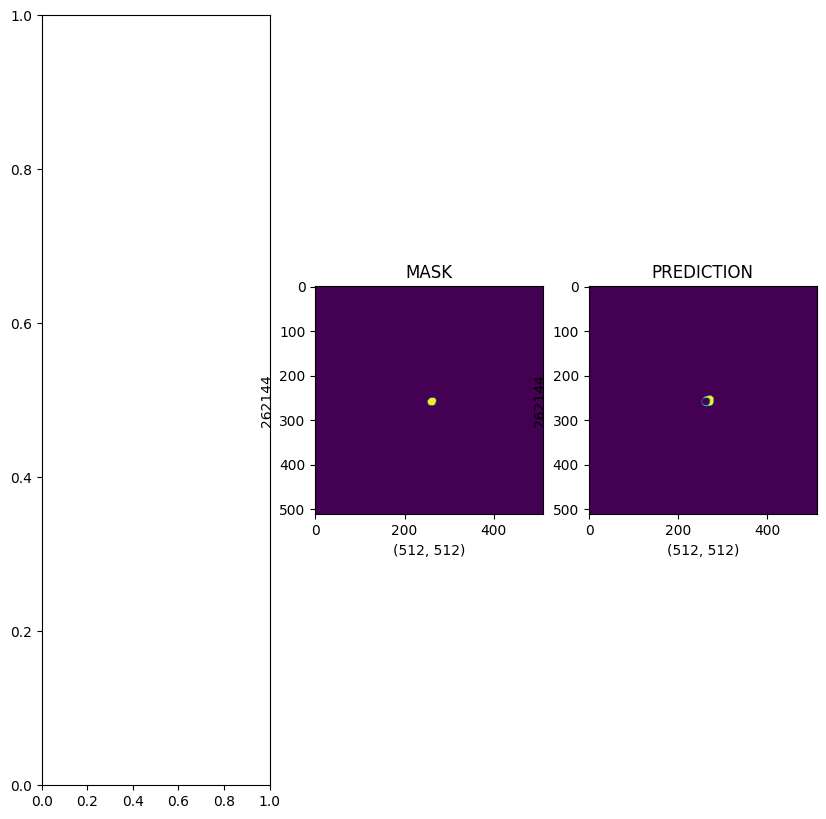

In [ ]:
# ]np.argmax(output[:3], axis=0)
img = stk_valid_dataset[1]['pixel_values'].numpy().astype(np.uint8)
img = np.squeeze(img)
label = stk_valid_dataset[1]['labels'].numpy().astype(np.uint8)
pred_img = prediction_image

figure,axis = plt.subplots(1,3,figsize=(10,10))
# axis[0].imshow(img)
# axis[0].set_xlabel(img.shape)
# axis[0].set_ylabel(img.size)
# axis[0].set_title("IMAGE")

axis[1].imshow(label)
axis[1].set_xlabel(label.shape)
axis[1].set_ylabel(label.size)
axis[1].set_title("MASK")
axis[2].imshow(pred_img)
axis[2].set_xlabel(pred_img.shape)
axis[2].set_ylabel(pred_img.size)
axis[2].set_title("PREDICTION")

In [ ]:
# from datasets import load_dataset

# dataset = load_dataset("Cats-Can/pelvic_images")

In [ ]:
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 20.4 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

In [ ]:
class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label, train_dataloader=None,  test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        
        self.train_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        
    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)
    
    def training_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss})
      

    
    def test_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
            
        return({'test_loss': loss})
    
    def test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
       
        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}
        
        for k,v in metrics.items():
            self.log(k,v)
        
        return metrics
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_dl

    
    def test_dataloader(self):
        return self.test_dl

In [ ]:
batch_size = 4
num_workers = 2
train_dataloader = DataLoader(stk_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(stk_valid_dataset, batch_size=batch_size, num_workers=num_workers)

segformer_finetuner = SegformerFinetuner(
    id2label, 
    train_dataloader=train_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=10, 
    verbose=False, 
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    # gpus=1, 
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=1,
    val_check_interval=len(train_dataloader),
)
trainer.fit(segformer_finetuner)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M 
-----------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.860    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
trainer
